<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Athena - Portfolio Optimization using Machine Learning

## Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [1]:
!pip install yfinance
!pip install Riskfolio-Lib
!pip install PyPortfolioOpt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import scipy
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("All neccessary imports done!")

All neccessary imports done!


## Variables

In [2]:
time_steps = 60
features = 4

## Getting data from API

In [3]:
tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

In [4]:
def get_data(tickers, period="5y"):
  
  # download data of ticker symbol
  data = yf.download(tickers, period=period)
  info = []

  for ticker in tickers: 
    info.append(yf.Ticker(ticker).info)

  # # resetting index
  # data = data.reset_index()
  
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  return data, info

In [5]:
df, info = get_data(tickers)

[*********************100%***********************]  5 of 5 completed


In [6]:
df

Close                                                    
           ASIANPAINT.NS      IOC.NS     LUPIN.NS PIDILITIND.NS  RELIANCE.NS
Date                                                                        
2017-03-17   1079.449951  187.925003  1456.550049    701.900024   644.243225
2017-03-20   1079.699951  185.475006  1464.699951    699.500000   634.386658
2017-03-21   1068.699951  186.050003  1454.400024    700.150024   625.966492
2017-03-22   1057.849976  186.375000  1468.150024    693.299988   623.935730
2017-03-23   1061.599976  188.399994  1490.250000    693.849976   630.671875
...                  ...         ...          ...           ...          ...
2022-03-11   2932.000000  123.699997   747.900024   2338.149902  2399.149902
2022-03-14   2962.800049  120.800003   745.200012   2344.699951  2418.850098
2022-03-15   2987.149902  119.000000   737.950012   2370.550049  2363.449951
2022-03-16   3042.000000  121.949997   749.599976   2462.899902  2403.350098
2022-03-17   3136.600098  121.349998   765.349976   2510.399902  2481.699951

[1237 rows x 5 columns]

## Converting company info to DataFrame

In [7]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(info[0],orient='index')
infodf0 = infodf0.reset_index()
infodf0

,index,0
0,zip,400055
1,sector,Basic Materials
2,fullTimeEmployees,7134
3,longBusinessSummary,"Asian Paints Limited, together with its subsid..."
4,city,Mumbai
...,...,...
148,bidSize,0
149,dayHigh,3163.3
150,regularMarketPrice,3136.6
151,preMarketPrice,None


## Visualizing the data

<AxesSubplot:xlabel='Date'>

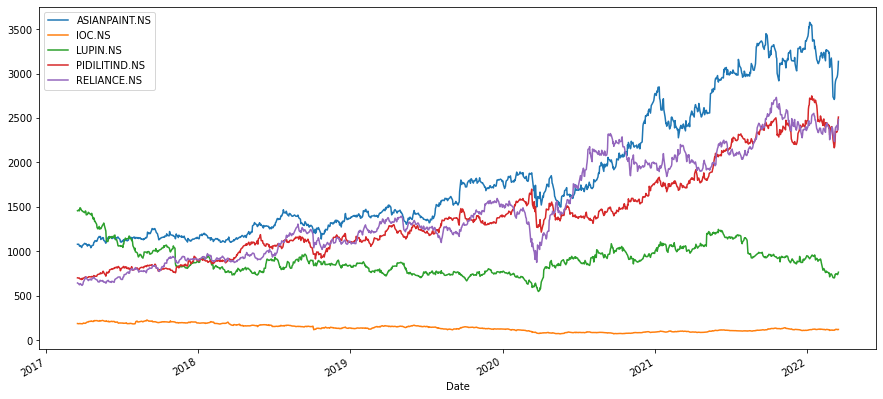

In [8]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df['Close'].plot(label = tickers, figsize = (15,7))

# Deep Learning model for future price prediction

## Using timesteps (Method 1)

### Preprocessing

In [9]:
# shifting is done here to ensure that the next day's price is predicted on the given day
df_shift = df.shift(-1)

label = df_shift['Close']

print(label)

Date
2017-03-17    1079.699951
2017-03-20    1068.699951
2017-03-21    1057.849976
2017-03-22    1061.599976
2017-03-23    1064.250000
                 ...     
2022-03-11    2962.800049
2022-03-14    2987.149902
2022-03-15    3042.000000
2022-03-16    3136.600098
2022-03-17            NaN
Name: Close, Length: 1237, dtype: float64


In [10]:
# adjusting the shape of both df and label (since label contains NaN as the last value)

df.drop(df.index[len(df)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

In [11]:
# conversion to numpy array

x, y = df.values, label.values

In [12]:
# Scaling to normalize the data. MinMaxScaler scales all the data to be in the region of 0 and 1.

x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))

In [13]:
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,1))

print("X",X)
print("Y",Y)

print(X[time_steps - 1])
print(Y[time_steps - 1])

X [[0.01823738 0.0142857  0.01651804 0.01537946]
 [0.01490538 0.01065509 0.01337842 0.01547804]
 [0.01496449 0.01142461 0.01189857 0.01114025]
 ...
 [0.75157729 0.75625497 0.75334962 0.7580693 ]
 [0.77050473 0.77979479 0.77282727 0.76767154]
 [0.78824921 0.78689818 0.79072512 0.78930141]]
Y [[0.01547804]
 [0.01114025]
 [0.00686161]
 ...
 [0.76767154]
 [0.78930141]
 [0.82660649]]
[0.04093062 0.04060774 0.0425549  0.04538916]
[0.04363429]


### Splitting training and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)

In [16]:
print(X_train.shape)
print(X_test.shape)

(741, 4)
(495, 4)


### Adding timesteps

In [17]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(time_steps, len(X_train)):
  X_train_new.append(X_train[i-time_steps:i, :])
  y_train_new.append(y_train[i-1])


for i in range(time_steps, len(X_test)):
  X_test_new.append(X_test[i-time_steps:i, :])
  y_test_new.append(y_test[i-1])

### Converting train and test to numpy arrays and reshaping

In [18]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(641, 100, 4)
(641, 1)
(395, 100, 4)
(395, 1)


In [19]:
X_train_new = X_train_new.reshape(-1,time_steps,features)
X_test_new = X_test_new.reshape(-1,time_steps,features)

## Using timesteps (Method 2)

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))

df = scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# Training data is 60% of the whole data. The rest is test data
training_size=int(len(df)*0.6)
test_size=len(df)-training_size

train_data,test_data=df[0:training_size,:],df[training_size:len(df), :1]

In [ ]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):

    # a = dataset[i:(i+time_step), :]
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    # dataY.append(dataset[i + time_step, 3])
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(641, 100)
(394, 100)
(641,)
(394,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print(X_train.shape)
print(X_test.shape)

(641, 100, 1)
(394, 100, 1)


## Deep learning model (GRU)

In [20]:
gru_model = Sequential()
gru_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(time_steps, features)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=256))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(1))

gru_model.compile(loss='mse', optimizer='adam')

In [21]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 512)          794112    
                                                                 
 dropout (Dropout)           (None, 100, 512)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               590592    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,384,961
Trainable params: 1,384,961
Non-trainable params: 0
_________________________________________________________________


In [22]:
with tf.device('/device:GPU:0'):
  gru_model.fit(X_train_new,y_train_new,batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.0116 - val_loss: 4.2846e-04
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - val_loss: 0.0094
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0013 - val_loss: 6.4867e-04
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 7.9975e-04 - val_loss: 0.0013
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 4.2677e-04 - val_loss: 0.0013
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 4.8688e-04 - val_loss: 0.0016
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 3.7378e-04 - val_loss: 3.1776e-04
Epoch 8/100
3/3 [==============================] - 3s 1s/step - loss: 2.4007e-04 - val_loss: 9.8005e-04
Epoch 9/100
3/3 [==============================] - 3s 1s/step - loss: 3.0818e-04 - val_loss: 3.1456e-04
Epoch 10/100
3/3 [==============================] - 3s 1s/step - loss: 1.8822e-04 - val_loss

In [23]:
gru_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_features_4_timesteps_100.h5")
print('GRU Model saved!')

GRU Model saved!


## Deep Learning Model (LSTM)

In [31]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(time_steps, features)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=256))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.compile(loss='mse', optimizer='adam')

In [32]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1058816   
                                                                 
 dropout_2 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,846,529
Trainable params: 1,846,529
Non-trainable params: 0
_________________________________________________________________


In [33]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(X_train_new, y_train_new, batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 11s 2s/step - loss: 0.0131 - val_loss: 8.9365e-04
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.0024 - val_loss: 0.0189
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.0027 - val_loss: 7.3096e-04
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 9.9523e-04 - val_loss: 6.7175e-04
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 6.6578e-04 - val_loss: 0.0037
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 8.5678e-04 - val_loss: 0.0040
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 6.4141e-04 - val_loss: 5.1687e-04
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 3.9544e-04 - val_loss: 7.3941e-04
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 3.6965e-04 - val_loss: 6.3958e-04
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 2.9893e-04 - val

In [34]:
# Saving the model in drive
lstm_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/LSTM_features_4_timesteps_100.h5")
print('LSTM Model saved!') 

LSTM Model saved!


## Prediction

In [35]:
model = lstm_model

13/13 [==============================] - 2s 134ms/step - loss: 0.0021
Score: 0.002107418142259121


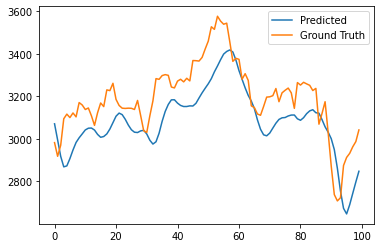

In [36]:
score = model.evaluate(X_test_new, y_test_new)

print('Score: {}'.format(score))

yhat = model.predict(X_test_new)

# inverse transform is used to convert the scaled values back to original values

# predicted output
yhat = y_scale.inverse_transform(yhat)

# original output
y_test = y_scale.inverse_transform(y_test_new)

# Prediction plot
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Ground Truth')
plt.legend()
plt.show()

## Next day stock price prediction

In [14]:
load_model = load_model("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_features_4_timesteps_100.h5")
print("Model loaded!")

Model loaded!


In [15]:
df_pred = get_data(tickers)
df_pred = df_pred.iloc[len(df_pred) - time_steps:len(df_pred)]
print(df_pred)
df_pred = df_pred.values

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close
Date                                                          
2021-10-25  2950.000000  2950.000000  2857.250000  2918.050049
2021-10-26  2918.050049  3024.000000  2898.000000  2969.800049
2021-10-27  3029.199951  3145.000000  3029.199951  3094.649902
2021-10-28  3103.000000  3147.600098  3062.000000  3116.300049
2021-10-29  3125.000000  3144.699951  3083.300049  3100.100098
...                 ...          ...          ...          ...
2022-03-11  2917.000000  2939.949951  2882.350098  2932.000000
2022-03-14  2950.000000  2972.350098  2917.300049  2962.800049
2022-03-15  2998.000000  3032.000000  2966.000000  2987.149902
2022-03-16  3043.000000  3050.000000  3010.750000  3042.000000
2022-03-17  3113.500000  3163.300049  3076.500000  3136.600098

[100 rows x 4 columns]


In [16]:
x_pred = x_scale.transform(df_pred)

print(x_pred.shape)

(100, 4)


In [17]:
next_day_price = load_model.predict(x_pred.reshape(-1,time_steps,features))

In [18]:
print(y_scale.inverse_transform(next_day_price))

[[3073.656]]


# Deep Learning Model for Portfolio Optimization

# Helper functions for calculating expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [184]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN
  # annualise daily returns. 252 trading days in a year
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix*252,weights)))

  # SHARPE RATIO
  sharpe_ratio = (expected_return - 0.02) / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

# Statistical models (PyPortfolioOpt)

In [12]:
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns

     |████████████████████████████████| 61 kB 3.4 MB/s 
     |████████████████████████████████| 2.8 MB 10.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [13]:
df

Close                                                    
           ASIANPAINT.NS      IOC.NS     LUPIN.NS PIDILITIND.NS  RELIANCE.NS
Date                                                                        
2017-03-17   1079.449951  187.925003  1456.550049    701.900024   644.243225
2017-03-20   1079.699951  185.475006  1464.699951    699.500000   634.386658
2017-03-21   1068.699951  186.050003  1454.400024    700.150024   625.966492
2017-03-22   1057.849976  186.375000  1468.150024    693.299988   623.935730
2017-03-23   1061.599976  188.399994  1490.250000    693.849976   630.671875
...                  ...         ...          ...           ...          ...
2022-03-11   2932.000000  123.699997   747.900024   2338.149902  2399.149902
2022-03-14   2962.800049  120.800003   745.200012   2344.699951  2418.850098
2022-03-15   2987.149902  119.000000   737.950012   2370.550049  2363.449951
2022-03-16   3042.000000  121.949997   749.599976   2462.899902  2403.350098
2022-03-17   3136.600098  121.349998   765.349976   2510.399902  2481.699951

[1237 rows x 5 columns]

In [14]:
# pct_change() calculates the percent change values and dropna() drops the missing values
returns = df.pct_change().dropna()

returns

Close                                              
           ASIANPAINT.NS    IOC.NS  LUPIN.NS PIDILITIND.NS RELIANCE.NS
Date                                                                  
2017-03-20      0.000232 -0.013037  0.005595     -0.003419   -0.015299
2017-03-21     -0.010188  0.003100 -0.007032      0.000929   -0.013273
2017-03-22     -0.010152  0.001747  0.009454     -0.009784   -0.003244
2017-03-23      0.003545  0.010865  0.015053      0.000793    0.010796
2017-03-24      0.002496 -0.010881 -0.001644     -0.008071    0.010563
...                  ...       ...       ...           ...         ...
2022-03-11      0.006592  0.022737  0.011291     -0.005000    0.002884
2022-03-14      0.010505 -0.023444 -0.003610      0.002801    0.008211
2022-03-15      0.008219 -0.014901 -0.009729      0.011025   -0.022904
2022-03-16      0.018362  0.024790  0.015787      0.038957    0.016882
2022-03-17      0.031098 -0.004920  0.021011      0.019286    0.032600

[1236 rows x 5 columns]

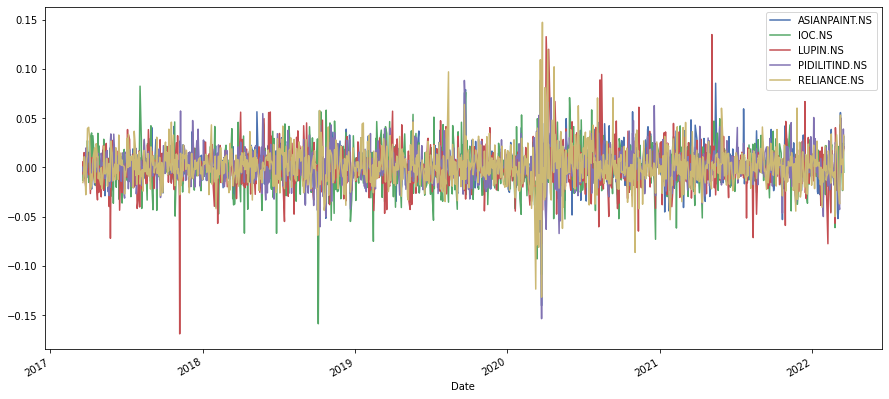

In [15]:
returns["Close"].plot(label = tickers, figsize = (15,7))

## HRP (Hierarchical Risk Parity) [Best Model]

In [16]:
# Using Hierarchical Risk Parity method to compute optimized portfolio weights
hrp = HRPOpt(returns)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([(('Close', 'ASIANPAINT.NS'), 0.18115),
             (('Close', 'IOC.NS'), 0.21242),
             (('Close', 'LUPIN.NS'), 0.22411),
             (('Close', 'PIDILITIND.NS'), 0.17966),
             (('Close', 'RELIANCE.NS'), 0.20266)])

In [19]:
weightsdf = pd.DataFrame.from_dict(weights, orient="index")
weightscol = weightsdf.iloc[:, 0]
weightscol

(Close, ASIANPAINT.NS)    0.18115
(Close, IOC.NS)           0.21242
(Close, LUPIN.NS)         0.22411
(Close, PIDILITIND.NS)    0.17966
(Close, RELIANCE.NS)      0.20266
Name: 0, dtype: float64

In [20]:
weightscol.sum()

1.0

In [48]:
hrp.portfolio_performance(verbose=True)

Expected annual return: 13.9%
Annual volatility: 19.2%
Sharpe Ratio: 0.62


(0.13903837254267337, 0.19236659996810446, 0.6188099834504048)

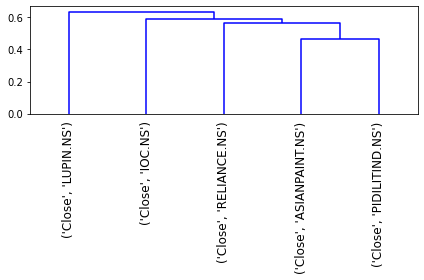

In [49]:
plotting.plot_dendrogram(hrp) 

## CLA (Critical Line Algorithm)

In [38]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

In [39]:
mu

Close  ASIANPAINT.NS    0.242941
       IOC.NS          -0.085311
       LUPIN.NS        -0.122955
       PIDILITIND.NS    0.296710
       RELIANCE.NS      0.316481
dtype: float64

In [34]:
S

Close                                    \
                    ASIANPAINT.NS    IOC.NS  LUPIN.NS PIDILITIND.NS   
Close ASIANPAINT.NS      0.070017  0.023275  0.009063      0.040019   
      IOC.NS             0.023275  0.107291  0.019123      0.024902   
      LUPIN.NS           0.009063  0.019123  0.101692      0.011666   
      PIDILITIND.NS      0.040019  0.024902  0.011666      0.070596   
      RELIANCE.NS        0.030536  0.031913  0.018938      0.026691   

                                 
                    RELIANCE.NS  
Close ASIANPAINT.NS    0.030536  
      IOC.NS           0.031913  
      LUPIN.NS         0.018938  
      PIDILITIND.NS    0.026691  
      RELIANCE.NS      0.098205

In [44]:
cla = CLA(mu, S)
cla.max_sharpe()
cla.clean_weights()

OrderedDict([(('Close', 'ASIANPAINT.NS'), 0.14747),
             (('Close', 'IOC.NS'), 0.0),
             (('Close', 'LUPIN.NS'), 0.0),
             (('Close', 'PIDILITIND.NS'), 0.48722),
             (('Close', 'RELIANCE.NS'), 0.36531)])

In [42]:
cla.portfolio_performance(verbose=True)

Expected annual return: 29.6%
Annual volatility: 22.3%
Sharpe Ratio: 1.24


(0.29600312375953075, 0.22344783664547857, 1.235201592922272)

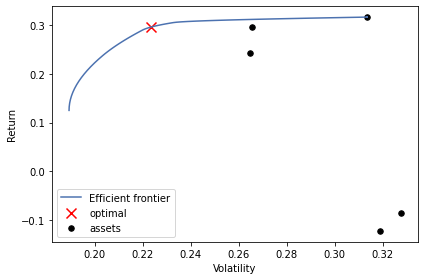

In [43]:
plotting.plot_efficient_frontier(cla)

# Statistical Models (RiskFolio-Lib) [Best Library]

In [9]:
import riskfolio as rp

In [10]:
# Calculating returns
Y = df['Close'].pct_change().dropna()
Y

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-20,0.000232,-0.013037,0.005595,-0.003419,-0.015299
2017-03-21,-0.010188,0.003100,-0.007032,0.000929,-0.013273
2017-03-22,-0.010152,0.001747,0.009454,-0.009784,-0.003244
2017-03-23,0.003545,0.010865,0.015053,0.000793,0.010796
2017-03-24,0.002496,-0.010881,-0.001644,-0.008071,0.010563
...,...,...,...,...,...
2022-03-11,0.006592,0.022737,0.011291,-0.005000,0.002884
2022-03-14,0.010505,-0.023444,-0.003610,0.002801,0.008211
2022-03-15,0.008219,-0.014901,-0.009729,0.011025,-0.022904


/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels[permutation], rotation=90, ha="center")
/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


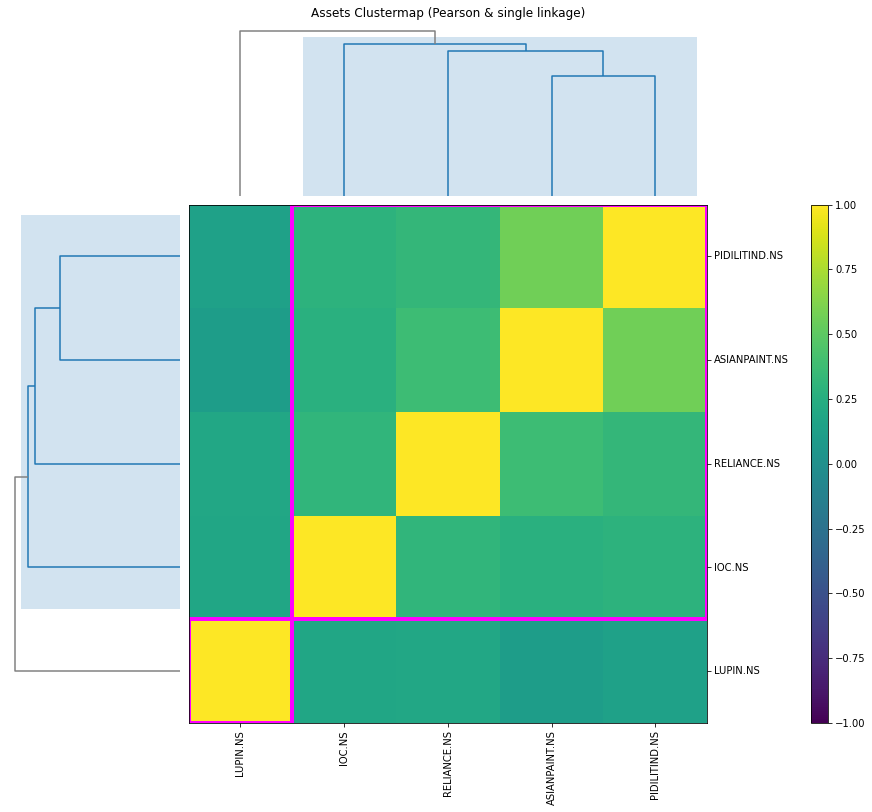

In [11]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

## HRP (Hierarchical Risk Parity)

In [43]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [190]:
# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk measure
rm = 'CDaR'
rf = 0 # Risk free rate
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w1.T)

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
weights,0.253569,0.087373,0.114356,0.229982,0.314719


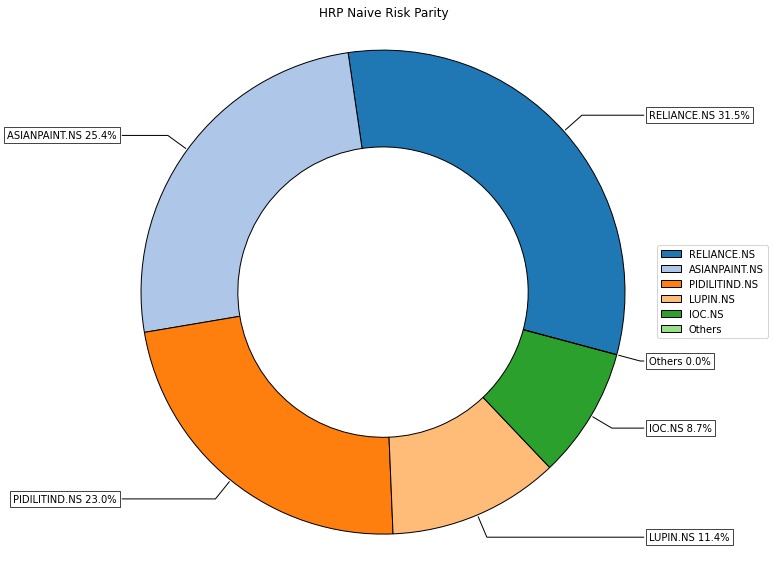

In [191]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

In [192]:
get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 22.17%
Annual Volatility: 20.05%
Sharpe Ratio: 1.01


## HERC (Hierarchical Equal Risk Contribution) [Better model than HRP] 

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

In [46]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

### Using two Risk measures - CDaR and Ulcer Index

Both of these risk measures are focused towards minimizing the risk of the portfolio and assigning optimal weights to make the portfolio more robust to market volatility rather than focusing only on maximing the returns.

In [47]:
# Estimate optimal portfolio:

model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w2.T)

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
weights,0.31113,0.048995,0.104636,0.300254,0.234984


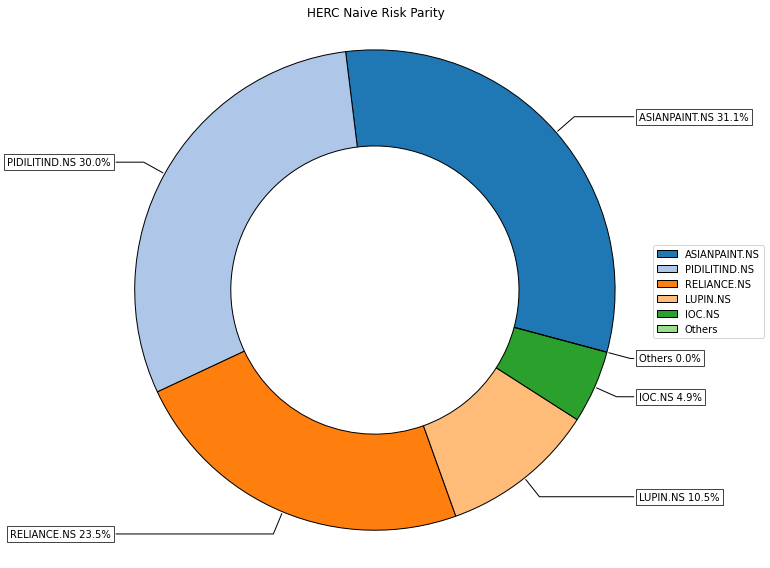

In [50]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

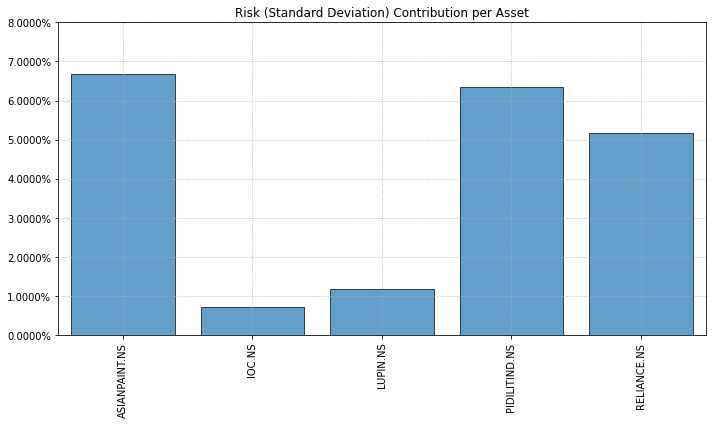

In [71]:
# Plotting the risk contribution graph of each asset


ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [186]:
get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 23.33%
Annual Volatility: 20.07%
Sharpe Ratio: 1.06
